In [106]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import RidgeCV

In [107]:
# Use fivethirtyeight styling, because I like it
import matplotlib.style as style
style.use('fivethirtyeight')

In [126]:
df = pd.read_csv('backup_df_from_scraping.csv')

In [127]:
df2 = df.copy()

In [128]:
# Drop rows that don't have a Walk Score
df2['walk_score'].dropna(inplace=True)

In [129]:
# Drop NAs for walk_score, income and transit_score columns
df2 = df2.dropna(subset=['walk_score'])
df2 = df2.dropna(subset=['income'])
df2 = df2.dropna(subset=['transit_score'])

In [169]:
# Drop columns we no longer need
df2 = df2.drop((['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'id', 'date', 'Address', 'bike_score', 'Neighborhood', 'GEOID', 'lat', 'long']), axis=1)

KeyError: "['Unnamed: 0' 'Unnamed: 0.1' 'Unnamed: 0.1.1' 'id' 'date' 'Address'\n 'Neighborhood' 'GEOID' 'lat' 'long'] not found in axis"

In [131]:
# Looking for outliers greater than 3 std's away from mean
df2['price'].mean() + (3 * df2['price'].std())

1577949.0168299316

In [133]:
# Drop outliers in price (230 records). Outliers = over 3 standard deviations greater than mean.
# 3 standard deviations greater than mean: $1,577,949
mask = df2[df2['price'] >=  (df2['price'].mean() + (3 * df2['price'].std()))]
df2.drop(mask.index, inplace=True)

In [138]:
df2.count()

price               14747
bedrooms            14747
bathrooms           14747
sqft_living         14747
sqft_lot            14747
floors              14747
waterfront          14747
view                14747
condition           14747
grade               14747
sqft_above          14747
sqft_basement       14747
yr_built            14747
yr_renovated        14747
zipcode             14747
sqft_living15       14747
sqft_lot15          14747
walk_score          14747
bike_score           7110
transit_score       14747
pers_crime_score     5852
prop_crime_score     5852
income              14747
dtype: int64

In [135]:
# Cleaning single digit columns from scraped data (it contained an extra backslash)
# Recasting columns as integers rather than float

def remove_chars(x):
    if '/' in x:
        x=x[1]
    return x

df2['walk_score'] = df2['walk_score'].apply(remove_chars).astype('int')
df2['transit_score'] = df2['transit_score'].astype('str').apply(remove_chars).astype('int')
df2['income'] = df2['income'].astype('int')

In [136]:
df2.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15',
       'sqft_lot15', 'walk_score', 'bike_score', 'transit_score',
       'pers_crime_score', 'prop_crime_score', 'income'],
      dtype='object')

In [137]:
# Drop duplicates. There were 5 duplicates.

df2.drop_duplicates(subset=['price',
       'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'sqft_living15', 'sqft_lot15'], inplace=True)

In [139]:
pd.to_numeric(df2['walk_score'], errors='coerce')

0        46
1        64
2        19
3        42
4        35
5         0
6        27
8        49
9        34
10       46
11       72
13       32
14       83
15       65
17       34
18       51
19       32
20       82
22       20
23       27
24       17
26       94
27       95
28       71
29        8
30        9
31       53
32       72
33       86
34       13
         ..
21569    79
21570    47
21571    22
21572    84
21573     7
21574    89
21575    45
21578    62
21579    83
21582    81
21583    77
21584    93
21585    12
21586    96
21589     6
21591    34
21592    89
21595    91
21597    15
21598     5
21599     3
21600    54
21604    80
21606    14
21607    70
21608    84
21609    62
21610    72
21611     8
21612    65
Name: walk_score, Length: 14747, dtype: int64

In [140]:
df2['transit_score'] = df2['transit_score'].astype('str').apply(remove_chars).astype('int')

In [149]:
df3 = df2.copy()

In [150]:
df3 = df3.dropna(subset=['pers_crime_score'])

In [152]:
# Limit the data set to 500 rows for now, to make processing for model validation and selection faster.
# Get a random sample of the entire dataframe
df3 = df3.sample(n=500, replace=False, random_state=12, axis=0)

In [155]:
# Create variable for the log of price, since our data is positively skewed
df3['log_price'] = df3['price'].apply(lambda x: np.log(x))

/Users/brenner/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


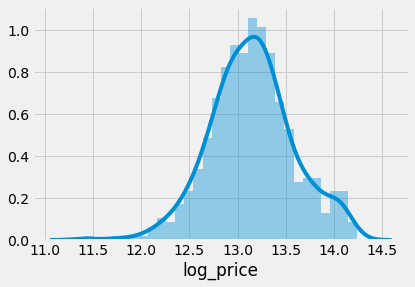

In [183]:
fig, ax = plt.subplots()
# ax.set_xlim([0,2000000])
sns.distplot(df3['log_price'], bins=30)

In [184]:
df3.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15',
       'sqft_lot15', 'walk_score', 'bike_score', 'transit_score',
       'pers_crime_score', 'prop_crime_score', 'income', 'log_price',
       'renovated_2'],
      dtype='object')

In [185]:
X = df3[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15',
       'sqft_lot15', 'walk_score', 'transit_score',
       'pers_crime_score', 'prop_crime_score', 'income']]

In [163]:
# Creating a new column that makes year_renovated equal to year built if the building has not been renovated.

df3['renovated_2'] = df3['yr_renovated']
df3.loc[df3['yr_renovated']==0, 'renovated_2'] = df3['yr_built']

In [164]:
# Changing letter grades to numerical values

def make_grade_numerical(x):
    if x=='A':
        return 1
    elif x=='B':
        return 2
    elif x=='C':
        return 3
    elif x=='D':
        return 4
    elif x=='E':
        return 5
    else:
        return x
    

df3['prop_crime_score'] = df3['prop_crime_score'].apply(make_grade_numerical)
df3['pers_crime_score'] = df3['prop_crime_score'].apply(make_grade_numerical)

In [165]:
# Making the crime scores numerical since they were letter grades before
pd.to_numeric(df3['prop_crime_score'], errors='coerce')
pd.to_numeric(df3['pers_crime_score'], errors='coerce')

16932    1
1050     1
19536    3
21608    3
18059    2
20012    1
12611    3
4187     2
17632    3
1781     1
13396    1
6365     2
10101    2
8497     3
21305    2
18888    2
8257     1
13921    3
14359    2
1497     2
14860    1
20029    2
15049    1
14473    2
20701    2
17100    2
1670     2
1160     2
15016    4
4178     2
        ..
3395     1
20869    2
1907     3
8246     2
20647    1
8965     3
20797    2
7076     1
7533     2
14918    2
3110     1
7254     1
17076    3
1216     2
9452     1
2174     3
1934     3
20081    4
7428     1
9678     3
9443     1
4746     4
12559    2
14781    1
16186    2
8340     4
1199     2
9152     1
1458     2
2949     3
Name: pers_crime_score, Length: 500, dtype: int64

In [166]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 16932 to 2949
Data columns (total 25 columns):
price               500 non-null int64
bedrooms            500 non-null int64
bathrooms           500 non-null float64
sqft_living         500 non-null int64
sqft_lot            500 non-null int64
floors              500 non-null float64
waterfront          500 non-null int64
view                500 non-null int64
condition           500 non-null int64
grade               500 non-null int64
sqft_above          500 non-null int64
sqft_basement       500 non-null int64
yr_built            500 non-null int64
yr_renovated        500 non-null int64
zipcode             500 non-null int64
sqft_living15       500 non-null int64
sqft_lot15          500 non-null int64
walk_score          500 non-null int64
bike_score          500 non-null object
transit_score       500 non-null int64
pers_crime_score    500 non-null int64
prop_crime_score    500 non-null int64
income              500 non

In [170]:
df3.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15',
       'sqft_lot15', 'walk_score', 'bike_score', 'transit_score',
       'pers_crime_score', 'prop_crime_score', 'income', 'log_price',
       'renovated_2'],
      dtype='object')

In [171]:
# Set our X and y in preparation for train/test/split
X = df3[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       'sqft_lot15', 'walk_score', 'transit_score',
       'pers_crime_score', 'prop_crime_score', 'income',
       'renovated_2']]

y = df3['log_price']

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [173]:
lm = LinearRegression()

In [174]:
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [175]:
predictions = lm.predict(X_test)

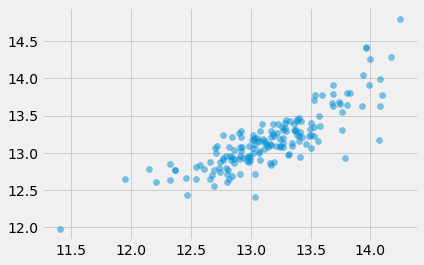

In [176]:
plt.scatter(y_test, predictions, alpha=0.5)

In [52]:
y_test.shape

(165,)

In [51]:
predictions.shape

(165,)

In [53]:
from sklearn.cross_validation import cross_val_score

In [54]:
scores = cross_val_score(lm, X, y, cv=10, scoring='r2')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print('Rˆ2 for each cross-val:',scores,'\n')
print('Mean Rˆ2 of all cross vals:',np.mean(scores),'+-',np.std(scores))

Rˆ2 for each cross-val: [0.71830203 0.80427593 0.71369998 0.72889165 0.64083546 0.66920115
 0.65603825 0.79148352 0.73024217 0.74944131] 

Mean Rˆ2 of all cross vals: 0.7202411447544681 +- 0.05122863005217873


In [31]:
degree = 5
est = make_pipeline(PolynomialFeatures(degree), StandardScaler(), 
                    RidgeCV(cv=3,alphas=(1e-14,1e-8,1e-2,100)))


est.fit(X_train, y_train)
print('Train R^2: ',est.score(X_train, y_train))
print('Train SSE:', 
      mean_squared_error(y_train, est.predict(X_train)))
print('Test R^2: ', est.score(X_test, y_test))
print('Test SSE:', 
      mean_squared_error(y_test, est.predict(X_test)))b

/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.268399e-19
  overwrite_a=False)


Train R^2:  0.9352479234619118


NameError: name 'mean_squared_error' is not defined

In [36]:
print(est.get_params)

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=5, include_bias=True, interaction_only=False)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridgecv', RidgeCV(alphas=(1e-14, 1e-08, 0.01, 100), cv=3, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False))])>

Compare the SSE from both the Ridge and RidgeCV

In [ ]:
print('Test SSE RidgeCV:', 
      mean_squared_error(y_test, est.predict(X_test)))
print('Test SSE Ridge:', min(sse_te_Ridge))

Compare the $R^2$ from both the Ridge and RidgeCV

In [ ]:
print('Test R^2 RidgeCV: ', est.score(X_test, y_test))
print('Test R^2 Ridge: ', max(r2_te_Ridge))

# Cross Validation

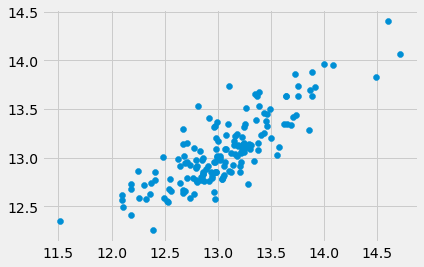

In [58]:
est = make_pipeline(PolynomialFeatures(1), LinearRegression())
est.fit(X_train, y_train)
predictions = est.predict(X_test)
plt.scatter(y_test, predictions)

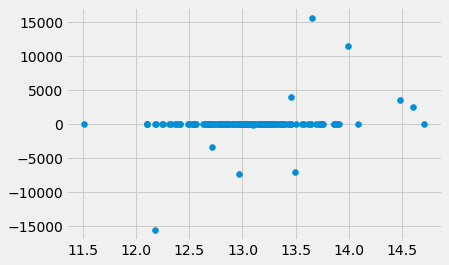

In [59]:
est = make_pipeline(PolynomialFeatures(2), LinearRegression())
est.fit(X_train, y_train)
predictions = est.predict(X_test)
plt.scatter(y_test, predictions)

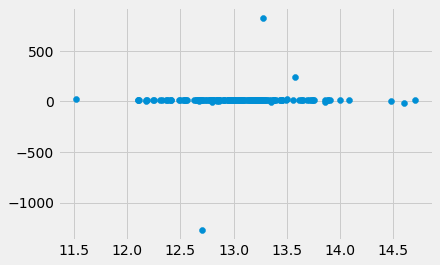

In [60]:
est = make_pipeline(PolynomialFeatures(3), LinearRegression())
est.fit(X_train, y_train)
predictions = est.predict(X_test)
plt.scatter(y_test, predictions)

In [186]:

# 10-fold cross-validation with our fake data
reg = LinearRegression()
scores = cross_val_score(reg, X, y, cv=10, scoring='r2')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print('Rˆ2 for each cross-val:',scores,'\n')
print('Mean Rˆ2 of all cross vals:',np.mean(scores),'+-',np.std(scores))

Rˆ2 for each cross-val: [0.7340448  0.70679345 0.71674185 0.77909854 0.71522665 0.67057399
 0.82862867 0.76073948 0.59489295 0.72843891] 

Mean Rˆ2 of all cross vals: 0.7235179296639307 +- 0.05949769865800799


In [187]:
# 10-fold cross-validation with our fake data
reg = LinearRegression()
scores = cross_val_score(reg, X, y, cv=10, scoring='mean_squared_error')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print('Mean for each cross-val:',-scores,'\n')
print('Mean of all cross vals:',np.mean(-scores),'+-',np.std(-scores))

Mean for each cross-val: [0.03574912 0.06313312 0.04182669 0.05228916 0.08856836 0.04294565
 0.03265604 0.03814672 0.05781672 0.05139146] 

Mean of all cross vals: 0.050452305036783995 +- 0.015770847965118434


/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_

In [ ]:
reg = LinearRegression()
res_cv = {}
res_train = {}
for degree in range(20):
    
    # transforms the data to polynomials
    poly = PolynomialFeatures(degree)
    X1 = poly.fit_transform(X)
    
    # calculates the MSE for CV
    scores = cross_val_score(reg, X1, y, cv=10, scoring='mean_squared_error') # cross val
    res_cv[degree] = np.mean(-scores)
    
    # calculates the MSE for Training Set
    reg.fit(X1,y)
    y_pred = reg.predict(X1)
    res_train[degree] = np.sum((y_pred-y)**2)/len(y)

/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_

In [ ]:
degrees = list(res_cv.keys())
mse_cv = list(res_cv.values())
mse_train = list(res_train.values())

plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
plt.plot(degrees,mse_cv)
plt.plot(degrees,mse_train)
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.title('Normal Scale')
plt.legend(['CV','Train'])

plt.subplot(1,2,2)
plt.semilogy(degrees,mse_cv)
plt.semilogy(degrees,mse_train)
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.title('Log Scale')

loc = np.argmin(list(res_cv.values()))
print('The degree',degrees[loc],'had an MSE of:',mse_cv[loc])